In [1]:
#!/usr/bin/env python3
"""
LSTM IoT Intrusion Detection Model - Memory Efficient Version
60-20-20 Train-Val-Test Split
Max 5 files loaded at once
Streams validation/test data to avoid OOM
"""

import os
import sys
import gc
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import kagglehub
import warnings
warnings.filterwarnings('ignore')

# ==========================================================
# 🧹 HELPER FUNCTIONS
# ==========================================================

def load_and_clean(path, label_col=None):
    """Load CSV and separate features from labels"""
    df = pd.read_csv(path)
    df = df.dropna()
    df = df.drop_duplicates()

    if label_col is None:
        label_col = "Label" if "Label" in df.columns else df.columns[-1]

    X = df.drop(columns=[label_col])
    y = df[label_col]
    return X, y


def encode_objects(X):
    """Encode categorical columns and convert to numpy array"""
    for col in X.select_dtypes(include=["object"]).columns:
        X[col] = LabelEncoder().fit_transform(X[col])
    return X.values


def process_files_generator(file_list, scaler, pca, label_encoder, batch_size=5):
    """Generator that yields batches of processed data without storing all in memory"""
    for i in range(0, len(file_list), batch_size):
        batch_files = file_list[i:i+batch_size]

        X_batch = []
        y_batch = []

        for f in batch_files:
            try:
                X, y = load_and_clean(f)
                X = encode_objects(X)

                # Transform
                X_scaled = scaler.transform(X)
                X_reduced = pca.transform(X_scaled)

                X_batch.append(X_reduced)
                y_batch.append(label_encoder.transform(y.astype(str)))

            except Exception as e:
                print(f"Error processing {f}: {e}")
                continue

        if X_batch:
            X_combined = np.vstack(X_batch)
            y_combined = np.hstack(y_batch)

            # Free memory
            del X_batch, y_batch
            gc.collect()

            yield X_combined, y_combined


class MemoryCallback(Callback):
    """Callback to monitor and clear memory"""
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()


# ==========================================================
# 📂 DOWNLOAD & SPLIT DATASET
# ==========================================================

print("=" * 60)
print("📥 Downloading CIC-IoT-2023 Dataset from Kaggle...")
print("=" * 60)

dataset_dir = kagglehub.dataset_download("akashdogra/cic-iot-2023")
print(f"✅ Dataset downloaded to: {dataset_dir}")

csv_files = sorted([
    os.path.join(dataset_dir, f)
    for f in os.listdir(dataset_dir)
    if f.endswith(".csv")
])

print(f"📂 Found {len(csv_files)} CSV files.")

# 60-20-20 split
n_files = len(csv_files)
train_idx = int(n_files * 0.60)
val_idx = int(n_files * 0.80)

train_files = csv_files[:train_idx]
val_files = csv_files[train_idx:val_idx]
test_files = csv_files[val_idx:]

print(f"\n📊 Dataset Split:")
print(f"   Training:   {len(train_files)} files")
print(f"   Validation: {len(val_files)} files")
print(f"   Testing:    {len(test_files)} files")

# ==========================================================
# 🏷️ FIT LABEL ENCODER
# ==========================================================

print("\n" + "=" * 60)
print("🏷️  Fitting Label Encoder...")
print("=" * 60)

all_labels = []
max_batch = 5

for i in range(0, len(train_files), max_batch):
    batch_files = train_files[i:i+max_batch]
    print(f"Processing batch {i//max_batch + 1}/{(len(train_files)-1)//max_batch + 1}")

    for f in batch_files:
        _, y = load_and_clean(f)
        all_labels.extend(list(y.astype(str)))

    # Free memory periodically
    if i % (max_batch * 4) == 0:
        gc.collect()

label_encoder = LabelEncoder()
label_encoder.fit(all_labels)
del all_labels
gc.collect()

print(f"✅ LabelEncoder fitted with {len(label_encoder.classes_)} classes")

# ==========================================================
# 🏗️ FIT SCALER & PCA
# ==========================================================

print("\n" + "=" * 60)
print("🏗️  Fitting Scaler & PCA...")
print("=" * 60)

scaler = StandardScaler()

# Auto-detect number of features
sample_X, _ = load_and_clean(train_files[0])
sample_X = encode_objects(sample_X)
n_features = sample_X.shape[1]
n_components = min(30, n_features)  # Use 30 components max for memory efficiency
del sample_X
gc.collect()

print(f"PCA will use {n_components} components (dataset has {n_features} features)")

pca = IncrementalPCA(n_components=n_components)

# Pass 1: Fit Scaler
print("Pass 1: Fitting Scaler...")
for i in range(0, len(train_files), max_batch):
    batch_files = train_files[i:i+max_batch]
    print(f"  Scaler batch {i//max_batch + 1}/{(len(train_files)-1)//max_batch + 1}")

    for f in batch_files:
        X, _ = load_and_clean(f)
        X = encode_objects(X)
        scaler.partial_fit(X)
        del X
        gc.collect()

print("✅ Scaler fitted")

# Pass 2: Fit PCA
print("\nPass 2: Fitting PCA...")
for i in range(0, len(train_files), max_batch):
    batch_files = train_files[i:i+max_batch]
    print(f"  PCA batch {i//max_batch + 1}/{(len(train_files)-1)//max_batch + 1}")

    for f in batch_files:
        X, _ = load_and_clean(f)
        X = encode_objects(X)
        X_scaled = scaler.transform(X)
        pca.partial_fit(X_scaled)
        del X, X_scaled
        gc.collect()

print(f"✅ PCA fitted with {pca.n_components_} components")
gc.collect()

# ==========================================================
# 🧠 BUILD LSTM MODEL
# ==========================================================

print("\n" + "=" * 60)
print("🧠 Building LSTM Model...")
print("=" * 60)

n_classes = len(label_encoder.classes_)

model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(1, n_components)),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ==========================================================
# 🎯 TRAINING WITH VALIDATION GENERATOR
# ==========================================================

print("\n" + "=" * 60)
print("🎯 Starting Training...")
print("=" * 60)

epochs = 30
batch_size = 512
files_per_epoch = 3  # Reduced to save memory

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_lstm_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

memory_callback = MemoryCallback()

for epoch in range(epochs):
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch+1}/{epochs}")
    print(f"{'='*60}")

    # Training data
    start = (epoch * files_per_epoch) % len(train_files)
    selected_files = train_files[start:start + files_per_epoch]

    if len(selected_files) < files_per_epoch:
        selected_files += train_files[:files_per_epoch - len(selected_files)]

    print(f"Training on {len(selected_files)} files")

    # Process training batch
    train_gen = process_files_generator(selected_files, scaler, pca, label_encoder, batch_size=files_per_epoch)

    for X_train, y_train in train_gen:
        y_train_cat = to_categorical(y_train, num_classes=n_classes)
        X_train = np.expand_dims(X_train, axis=1)

        # Validation data (stream one batch at a time)
        print(f"Loading validation batch...")
        val_gen = process_files_generator(val_files[:5], scaler, pca, label_encoder, batch_size=5)

        for X_val, y_val in val_gen:
            y_val_cat = to_categorical(y_val, num_classes=n_classes)
            X_val = np.expand_dims(X_val, axis=1)

            history = model.fit(
                X_train, y_train_cat,
                validation_data=(X_val, y_val_cat),
                epochs=1,
                batch_size=batch_size,
                verbose=1,
                callbacks=[early_stop, checkpoint, memory_callback]
            )

            # Free memory
            del X_val, y_val, y_val_cat
            gc.collect()
            break  # Use only first validation batch

        del X_train, y_train, y_train_cat
        gc.collect()

    if early_stop.stopped_epoch > 0:
        print(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
        break

    gc.collect()

# ==========================================================
# 📈 FINAL EVALUATION (STREAMING)
# ==========================================================

print("\n" + "=" * 60)
print("📈 Final Evaluation on Test Set (Streaming)")
print("=" * 60)

model.load_weights('best_lstm_model.keras')

y_true_all = []
y_pred_all = []

print("Evaluating on test set...")
test_gen = process_files_generator(test_files, scaler, pca, label_encoder, batch_size=5)

for batch_num, (X_test, y_test) in enumerate(test_gen):
    print(f"Test batch {batch_num + 1}/{(len(test_files)-1)//5 + 1}")

    X_test = np.expand_dims(X_test, axis=1)

    y_pred_probs = model.predict(X_test, batch_size=batch_size, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

    del X_test, y_test, y_pred_probs, y_pred
    gc.collect()

# Calculate metrics
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

accuracy = accuracy_score(y_true_all, y_pred_all)
precision = precision_score(y_true_all, y_pred_all, average='weighted', zero_division=0)
recall = recall_score(y_true_all, y_pred_all, average='weighted', zero_division=0)
f1 = f1_score(y_true_all, y_pred_all, average='weighted', zero_division=0)

print(f"\n📊 Test Set Performance:")
print(f"   Accuracy:  {accuracy:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")

print("\n✅ Training Complete! Model saved as 'best_lstm_model.keras'")
print("=" * 60)

📥 Downloading CIC-IoT-2023 Dataset from Kaggle...
Using Colab cache for faster access to the 'cic-iot-2023' dataset.
✅ Dataset downloaded to: /kaggle/input/cic-iot-2023
📂 Found 169 CSV files.

📊 Dataset Split:
   Training:   101 files
   Validation: 34 files
   Testing:    34 files

🏷️  Fitting Label Encoder...
Processing batch 1/21
Processing batch 2/21
Processing batch 3/21
Processing batch 4/21
Processing batch 5/21
Processing batch 6/21
Processing batch 7/21
Processing batch 8/21
Processing batch 9/21
Processing batch 10/21
Processing batch 11/21
Processing batch 12/21
Processing batch 13/21
Processing batch 14/21
Processing batch 15/21
Processing batch 16/21
Processing batch 17/21
Processing batch 18/21
Processing batch 19/21
Processing batch 20/21
Processing batch 21/21
✅ LabelEncoder fitted with 34 classes

🏗️  Fitting Scaler & PCA...
PCA will use 30 components (dataset has 46 features)
Pass 1: Fitting Scaler...
  Scaler batch 1/21
  Scaler batch 2/21
  Scaler batch 3/21
  Scale

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        24,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 34)             │         1,122 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,914 (152.01 KB)

 Trainable params: 38,914 (152.01 KB)

 Non-trainable params: 0 (0.00 B)


🎯 Starting Training...

EPOCH 1/30
Training on 3 files
Loading validation batch...
1429/1432 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6140 - loss: 1.2413
Epoch 1: val_accuracy improved from -inf to 0.78057, saving model to best_lstm_model.keras
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.6143 - loss: 1.2399 - val_accuracy: 0.7806 - val_loss: 0.4906
Restoring model weights from the end of the best epoch: 1.

EPOCH 2/30
Training on 3 files
Loading validation batch...
1362/1365 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7749 - loss: 0.5101
Epoch 1: val_accuracy improved from 0.78057 to 0.78486, saving model to best_lstm_model.keras
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.7750 - loss: 0.5101 - val_accuracy: 0.7849 - val_loss: 0.4853
Restoring model weights from the end of the best epoch: 1.

EPOCH 3/30
Training on 3 files
Loading validation batch...
1383/1383 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7847 - loss: 0.4856
Epoch 1: val_accu

📥 Downloading CIC-IoT-2023 Dataset from Kaggle...


100%|██████████| 2.77G/2.77G [00:30<00:00, 97.5MB/s]

Extracting files...


✅ Dataset downloaded to: /root/.cache/kagglehub/datasets/akashdogra/cic-iot-2023/versions/1
📂 Found 169 CSV files.

📊 Dataset Split:
   Training:   101 files
   Validation: 34 files
   Testing:    34 files

🏷️  Fitting Label Encoder...
Processing batch 1/21
Processing batch 2/21
Processing batch 3/21
Processing batch 4/21
Processing batch 5/21
Processing batch 6/21
Processing batch 7/21
Processing batch 8/21
Processing batch 9/21
Processing batch 10/21
Processing batch 11/21
Processing batch 12/21
Processing batch 13/21
Processing batch 14/21
Processing batch 15/21
Processing batch 16/21
Processing batch 17/21
Processing batch 18/21
Processing batch 19/21
Processing batch 20/21
Processing batch 21/21
✅ LabelEncoder fitted with 34 classes

🏗️  Fitting Scaler & PCA...
PCA will use 30 components (dataset has 46 features)
Pass 1: Fitting Scaler...
  Scaler batch 1/21
  Scaler batch 2/21
  Scaler batch 3/21
  Scaler batch 4/21
  Scaler batch 5/21
  Scaler batch 6/21
  Scaler batch 7/21
  Sc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        81,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 34)             │         2,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,026 (519.63 KB)

 Trainable params: 133,026 (519.63 KB)

 Non-trainable params: 0 (0.00 B)


🎯 Starting Training...

EPOCH 1/30
Training on 3 files
Loading validation batch...
1431/1432 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7263 - loss: 1.0949
Epoch 1: val_accuracy improved from -inf to 0.79945, saving model to best_lstm_model.keras
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 78s 51ms/step - accuracy: 0.7263 - loss: 1.0942 - val_accuracy: 0.7995 - val_loss: 0.4457
Restoring model weights from the end of the best epoch: 1.

EPOCH 2/30
Training on 3 files
Loading validation batch...
1364/1365 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7993 - loss: 0.4500
Epoch 1: val_accuracy improved from 0.79945 to 0.80615, saving model to best_lstm_model.keras
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 52s 38ms/step - accuracy: 0.7993 - loss: 0.4500 - val_accuracy: 0.8061 - val_loss: 0.4220
Restoring model weights from the end of the best epoch: 1.

EPOCH 3/30
Training on 3 files
Loading validation batch...
1382/1383 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8063 - loss: 0.4279
Epoch 1: val_accu

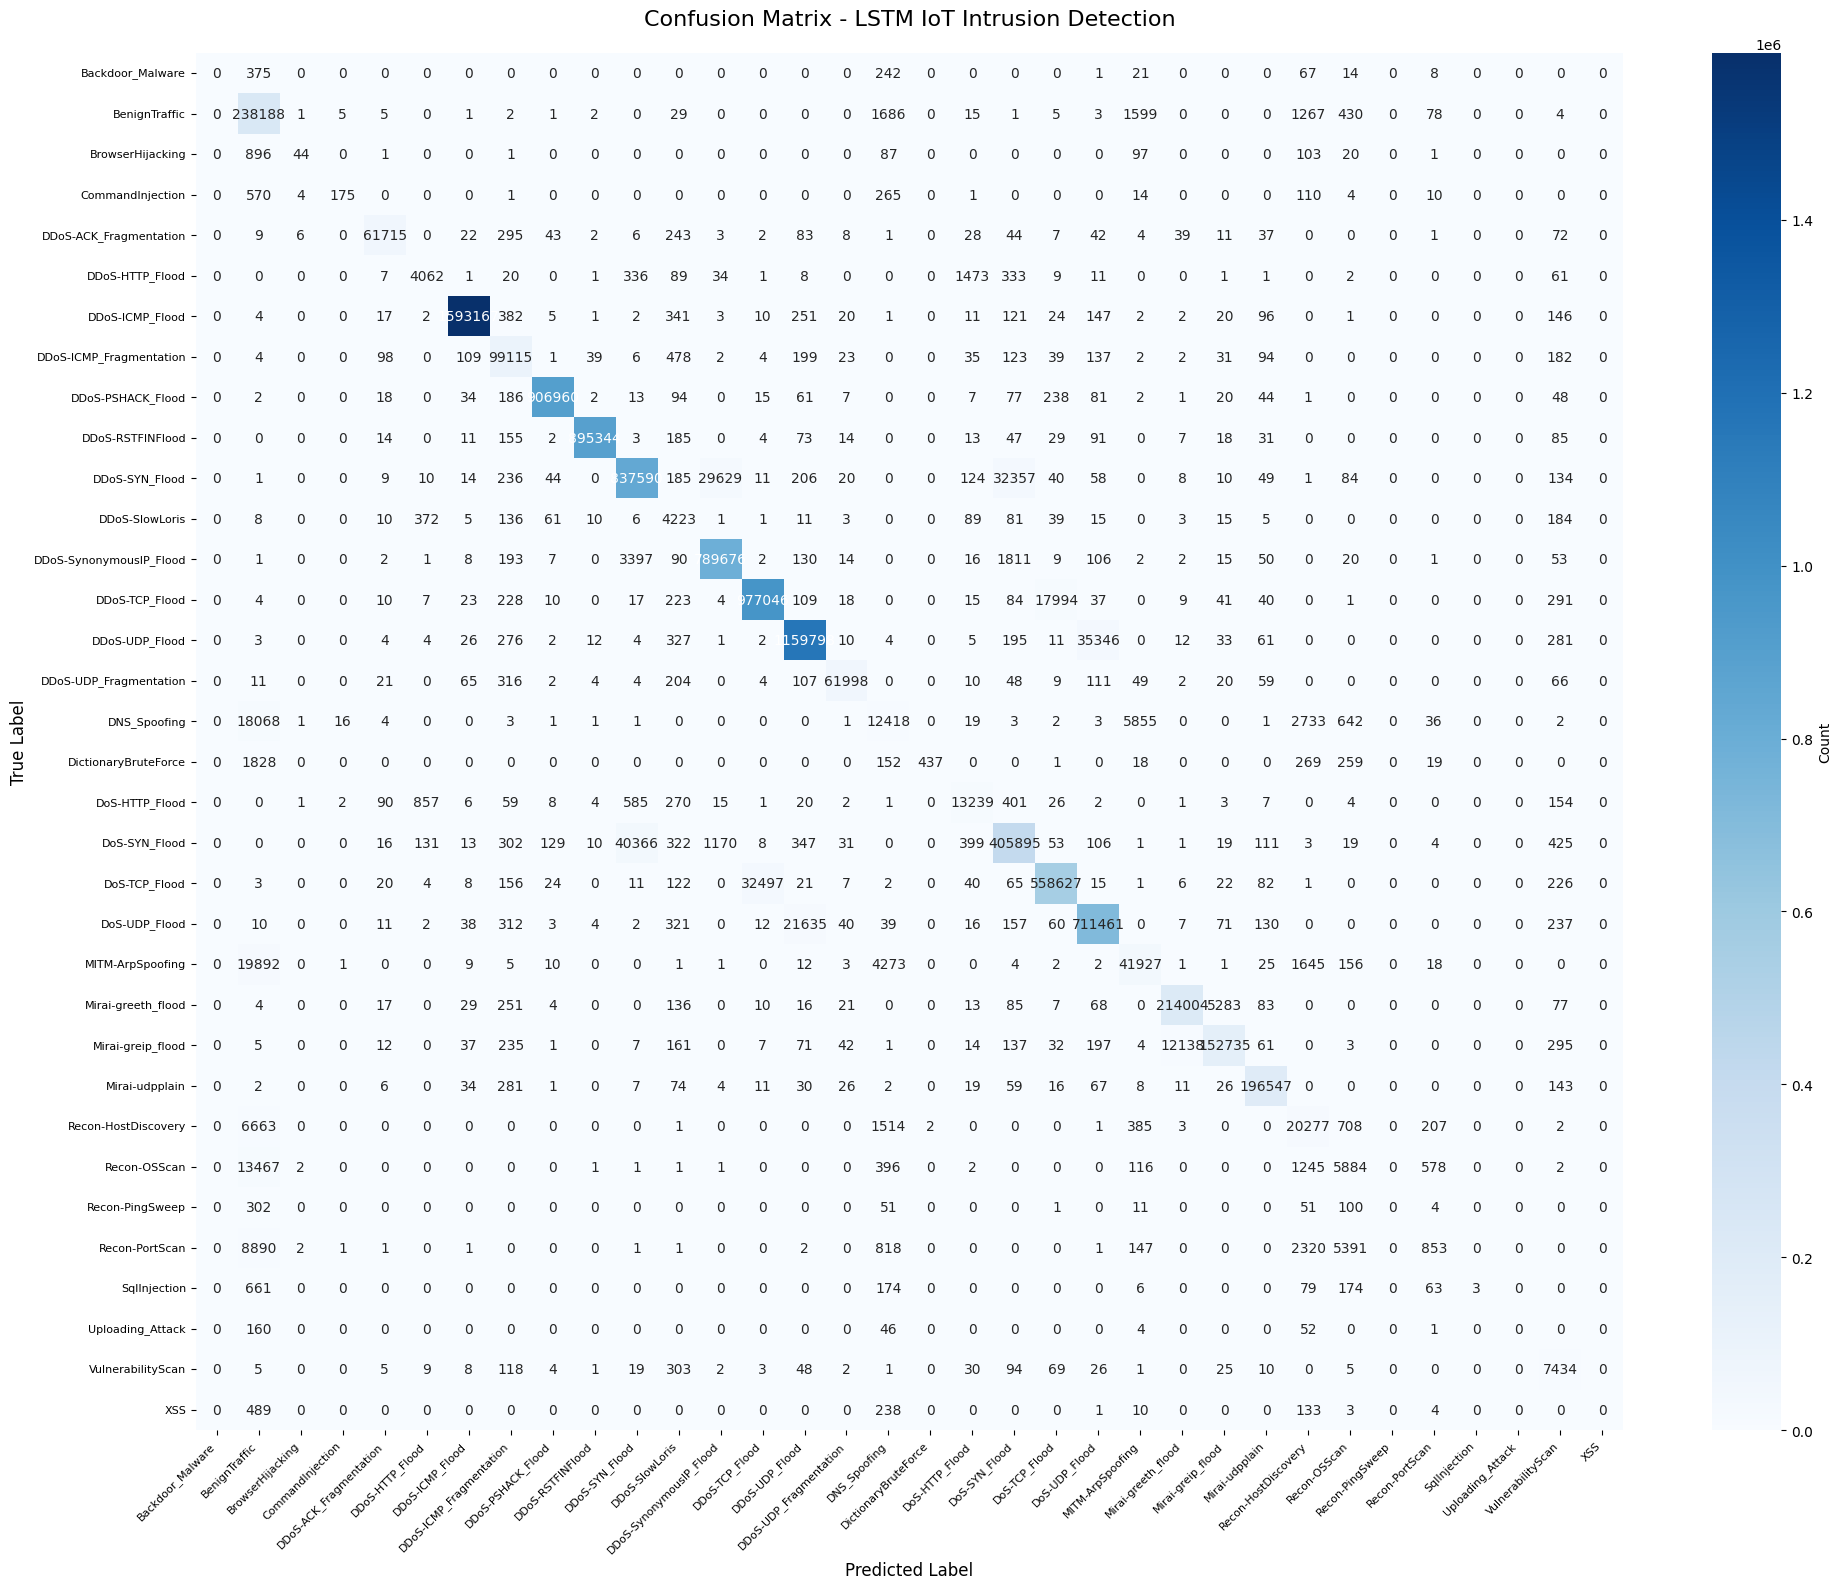

In [1]:
#!/usr/bin/env python3
"""
LSTM IoT Intrusion Detection Model - Memory Efficient Version
60-20-20 Train-Val-Test Split
Max 5 files loaded at once
Streams validation/test data to avoid OOM
"""

import os
import sys
import gc
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import kagglehub
import warnings
warnings.filterwarnings('ignore')

# ==========================================================
# 🧹 HELPER FUNCTIONS
# ==========================================================

def load_and_clean(path, label_col=None):
    """Load CSV and separate features from labels"""
    df = pd.read_csv(path)
    df = df.dropna()
    df = df.drop_duplicates()

    if label_col is None:
        label_col = "Label" if "Label" in df.columns else df.columns[-1]

    X = df.drop(columns=[label_col])
    y = df[label_col]
    return X, y


def encode_objects(X):
    """Encode categorical columns and convert to numpy array"""
    for col in X.select_dtypes(include=["object"]).columns:
        X[col] = LabelEncoder().fit_transform(X[col])
    return X.values


def process_files_generator(file_list, scaler, pca, label_encoder, batch_size=5):
    """Generator that yields batches of processed data without storing all in memory"""
    for i in range(0, len(file_list), batch_size):
        batch_files = file_list[i:i+batch_size]

        X_batch = []
        y_batch = []

        for f in batch_files:
            try:
                X, y = load_and_clean(f)
                X = encode_objects(X)

                # Transform
                X_scaled = scaler.transform(X)
                X_reduced = pca.transform(X_scaled)

                X_batch.append(X_reduced)
                y_batch.append(label_encoder.transform(y.astype(str)))

            except Exception as e:
                print(f"Error processing {f}: {e}")
                continue

        if X_batch:
            X_combined = np.vstack(X_batch)
            y_combined = np.hstack(y_batch)

            # Free memory
            del X_batch, y_batch
            gc.collect()

            yield X_combined, y_combined


class MemoryCallback(Callback):
    """Callback to monitor and clear memory"""
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()


# ==========================================================
# 📂 DOWNLOAD & SPLIT DATASET
# ==========================================================

print("=" * 60)
print("📥 Downloading CIC-IoT-2023 Dataset from Kaggle...")
print("=" * 60)

dataset_dir = kagglehub.dataset_download("akashdogra/cic-iot-2023")
print(f"✅ Dataset downloaded to: {dataset_dir}")

csv_files = sorted([
    os.path.join(dataset_dir, f)
    for f in os.listdir(dataset_dir)
    if f.endswith(".csv")
])

print(f"📂 Found {len(csv_files)} CSV files.")

# 60-20-20 split
n_files = len(csv_files)
train_idx = int(n_files * 0.60)
val_idx = int(n_files * 0.80)

train_files = csv_files[:train_idx]
val_files = csv_files[train_idx:val_idx]
test_files = csv_files[val_idx:]

print(f"\n📊 Dataset Split:")
print(f"   Training:   {len(train_files)} files")
print(f"   Validation: {len(val_files)} files")
print(f"   Testing:    {len(test_files)} files")

# ==========================================================
# 🏷️ FIT LABEL ENCODER
# ==========================================================

print("\n" + "=" * 60)
print("🏷️  Fitting Label Encoder...")
print("=" * 60)

all_labels = []
max_batch = 5

for i in range(0, len(train_files), max_batch):
    batch_files = train_files[i:i+max_batch]
    print(f"Processing batch {i//max_batch + 1}/{(len(train_files)-1)//max_batch + 1}")

    for f in batch_files:
        _, y = load_and_clean(f)
        all_labels.extend(list(y.astype(str)))

    # Free memory periodically
    if i % (max_batch * 4) == 0:
        gc.collect()

label_encoder = LabelEncoder()
label_encoder.fit(all_labels)
del all_labels
gc.collect()

print(f"✅ LabelEncoder fitted with {len(label_encoder.classes_)} classes")

# ==========================================================
# 🏗️ FIT SCALER & PCA
# ==========================================================

print("\n" + "=" * 60)
print("🏗️  Fitting Scaler & PCA...")
print("=" * 60)

scaler = StandardScaler()

# Auto-detect number of features
sample_X, _ = load_and_clean(train_files[0])
sample_X = encode_objects(sample_X)
n_features = sample_X.shape[1]
n_components = min(30, n_features)  # Use 30 components max for memory efficiency
del sample_X
gc.collect()

print(f"PCA will use {n_components} components (dataset has {n_features} features)")

pca = IncrementalPCA(n_components=n_components)

# Pass 1: Fit Scaler
print("Pass 1: Fitting Scaler...")
for i in range(0, len(train_files), max_batch):
    batch_files = train_files[i:i+max_batch]
    print(f"  Scaler batch {i//max_batch + 1}/{(len(train_files)-1)//max_batch + 1}")

    for f in batch_files:
        X, _ = load_and_clean(f)
        X = encode_objects(X)
        scaler.partial_fit(X)
        del X
        gc.collect()

print("✅ Scaler fitted")

# Pass 2: Fit PCA
print("\nPass 2: Fitting PCA...")
for i in range(0, len(train_files), max_batch):
    batch_files = train_files[i:i+max_batch]
    print(f"  PCA batch {i//max_batch + 1}/{(len(train_files)-1)//max_batch + 1}")

    for f in batch_files:
        X, _ = load_and_clean(f)
        X = encode_objects(X)
        X_scaled = scaler.transform(X)
        pca.partial_fit(X_scaled)
        del X, X_scaled
        gc.collect()

print(f"✅ PCA fitted with {pca.n_components_} components")
gc.collect()

# ==========================================================
# 🧠 BUILD LSTM MODEL
# ==========================================================

print("\n" + "=" * 60)
print("🧠 Building LSTM Model...")
print("=" * 60)

n_classes = len(label_encoder.classes_)

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(1, n_components)),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ==========================================================
# 🎯 TRAINING WITH VALIDATION GENERATOR
# ==========================================================

print("\n" + "=" * 60)
print("🎯 Starting Training...")
print("=" * 60)

epochs = 30
batch_size = 512
files_per_epoch = 3  # Reduced to save memory

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_lstm_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

memory_callback = MemoryCallback()

for epoch in range(epochs):
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch+1}/{epochs}")
    print(f"{'='*60}")

    # Training data
    start = (epoch * files_per_epoch) % len(train_files)
    selected_files = train_files[start:start + files_per_epoch]

    if len(selected_files) < files_per_epoch:
        selected_files += train_files[:files_per_epoch - len(selected_files)]

    print(f"Training on {len(selected_files)} files")

    # Process training batch
    train_gen = process_files_generator(selected_files, scaler, pca, label_encoder, batch_size=files_per_epoch)

    for X_train, y_train in train_gen:
        y_train_cat = to_categorical(y_train, num_classes=n_classes)
        X_train = np.expand_dims(X_train, axis=1)

        # Validation data (stream one batch at a time)
        print(f"Loading validation batch...")
        val_gen = process_files_generator(val_files[:5], scaler, pca, label_encoder, batch_size=5)

        for X_val, y_val in val_gen:
            y_val_cat = to_categorical(y_val, num_classes=n_classes)
            X_val = np.expand_dims(X_val, axis=1)

            history = model.fit(
                X_train, y_train_cat,
                validation_data=(X_val, y_val_cat),
                epochs=1,
                batch_size=batch_size,
                verbose=1,
                callbacks=[early_stop, checkpoint, memory_callback]
            )

            # Free memory
            del X_val, y_val, y_val_cat
            gc.collect()
            break  # Use only first validation batch

        del X_train, y_train, y_train_cat
        gc.collect()

    if early_stop.stopped_epoch > 0:
        print(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
        break

    gc.collect()

# ==========================================================
# 📈 FINAL EVALUATION (STREAMING)
# ==========================================================

print("\n" + "=" * 60)
print("📈 Final Evaluation on Test Set (Streaming)")
print("=" * 60)

model.load_weights('best_lstm_model.keras')

y_true_all = []
y_pred_all = []

print("Evaluating on test set...")
test_gen = process_files_generator(test_files, scaler, pca, label_encoder, batch_size=5)

for batch_num, (X_test, y_test) in enumerate(test_gen):
    print(f"Test batch {batch_num + 1}/{(len(test_files)-1)//5 + 1}")

    X_test = np.expand_dims(X_test, axis=1)

    y_pred_probs = model.predict(X_test, batch_size=batch_size, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

    del X_test, y_test, y_pred_probs, y_pred
    gc.collect()

# Calculate metrics
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

accuracy = accuracy_score(y_true_all, y_pred_all)
precision = precision_score(y_true_all, y_pred_all, average='weighted', zero_division=0)
recall = recall_score(y_true_all, y_pred_all, average='weighted', zero_division=0)
f1 = f1_score(y_true_all, y_pred_all, average='weighted', zero_division=0)

print(f"\n📊 Test Set Performance:")
print(f"   Accuracy:  {accuracy:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")

# ==========================================================
# 📊 CONFUSION MATRIX
# ==========================================================

print("\n" + "=" * 60)
print("📊 Generating Confusion Matrix...")
print("=" * 60)

cm = confusion_matrix(y_true_all, y_pred_all)

# Save confusion matrix plot
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - LSTM IoT Intrusion Detection', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✅ Confusion matrix saved as 'confusion_matrix.png'")

# Print confusion matrix in text format
print("\n📋 Confusion Matrix (Text Format):")
print("="*60)
print(f"{'True/Pred':<25}", end="")
for cls in label_encoder.classes_:
    print(f"{cls[:8]:>10}", end="")
print()
print("="*60)

for i, true_cls in enumerate(label_encoder.classes_):
    print(f"{true_cls:<25}", end="")
    for j in range(len(label_encoder.classes_)):
        print(f"{cm[i][j]:>10}", end="")
    print()

print("\n✅ Training Complete! Model saved as 'best_lstm_model.keras'")
print("=" * 60)